# Scalping Data Maintainment
    - Fetch newly available data occasionally and append it to old datasets
    - Include new currencies occasionally

### Imports

In [4]:
import pandas as pd 
import numpy as np
import os
from urllib.error import  HTTPError
import time
import datetime
from datetime import timedelta
from dateutil.parser import parse
import warnings
import ccxt
from ccxt.base.errors import RateLimitExceeded, BadSymbol
import tqdm

warnings.filterwarnings('ignore')

### Fetcher Class

In [5]:

class Scalping_Dataset_Fetcher:
    
    def __init__(self, fetcher_params):
        
        self.coins        = fetcher_params['coins'      ]        
        self.stable_coin  = fetcher_params['stable_coin']
        self.save_dir     = fetcher_params['save_dir'   ]          
        self.start_date   = fetcher_params['start_date' ][0:7]   # '2020-02-01' --> '2020-02' 
        self.end_date     = fetcher_params['end_date'   ][0:7]   # '2021-02-01' --> '2021-02'
        self.file_type    = fetcher_params['file_type'  ]                                                             
        self.freq         = fetcher_params['freq'       ] # 1 min can be upsampled to lower frequencies
        self.freq_pd      = fetcher_params['pd_freq'    ] 
        self.update_data  = fetcher_params['update_data'] # Decide either for refetching or partially refetching with updating 
        self.global_month_list = self.__get_global_month_list(self.start_date, self.end_date)
        self.current_coin      = None
        self.current_ticker    = None    
        
    def __get_global_month_list(self, start_date, end_date):
        """ Gets the monthly strings for data packages between 'start_date' and 'end_date' for all coins. """
    
        start_year = int(start_date[0:4])
        end_year   = int(end_date[0:4])
        years_between = end_year - start_year
        months = [f'{start_year + i}-{str(0) if j+1 < 10 else ""}{j+1}' #['2020-01', '2020-02', ..., '2023-04', '2023-05']
                    for i in range(years_between + 1) 
                        for j in range(12)]

        _month_list = months[months.index(start_date):months.index(end_date)+1]
        dt = datetime.datetime.now()
        last_possible_month = str(dt)[:7] # --> '2023-05'
        if last_possible_month in _month_list:
            _idx = _month_list.index(last_possible_month)
            _month_list = _month_list[:_idx] # at 26.05.2023 end_date can at max be '2023-05' and not '2023-06'

        return _month_list # --> ['2020-02', '2020-03', ..., '2023-05']

    def __get_global_updating_month_list(self, cls_start_date, cls_end_date, fn_start_date, fn_end_date):
        """ Gets the monthly strings for data packages between 'start_date'/'fn_start_date' and 
            'end_date'/'fn_end_date' for one specific coin.
           
            Correctly fills monthly gaps between 'cls_start_date' and 'fn_start_date' and between
            'cls_end_date' and 'fn_end_date' if missing months occur. 
        """
        
        start_year_cls,  start_year_fn  = int(cls_start_date[0:4]), int(fn_start_date[0:4])
        start_month_cls, start_month_fn = int(cls_start_date[5:7]), int(fn_start_date[5:7])

        end_year_cls,  end_year_fn      = int(cls_end_date[0:4]),   int(fn_end_date[0:4])
        end_month_cls, end_month_fn     = int(cls_end_date[5:7]),   int(fn_end_date[5:7])
        
        # Get the earliest starting date:
        if start_year_cls < start_year_fn:
            start_year  = start_year_cls
            start_month = start_month_cls
        elif start_year_cls > start_year_fn: 
            start_year = start_year_fn
            start_month = start_month_fn
        elif start_year_cls == start_year_fn: 
            if start_month_cls <= start_month_fn:
                start_year  = start_year_cls
                start_month = start_month_cls
            elif start_month_cls > start_month_fn: 
                start_year = start_year_fn
                start_month = start_month_fn
         
        # Get the latest end date:
        if end_year_cls > end_year_fn:
            end_year  = end_year_cls
            end_month = end_month_cls
        elif end_year_cls < end_year_fn: 
            end_year = end_year_fn
            end_month = end_month_fn
        elif end_year_cls == end_year_fn: 
            if end_month_cls >= end_month_fn:
                end_year  = end_year_cls
                end_month = end_month_cls
            elif end_month_cls < end_month_fn: 
                end_year = end_year_fn
                end_month = end_month_fn
        
        
        start_date = str(start_year) + '-' + ('0' if start_month < 10 else '') + str(start_month)
        end_date   = str(end_year)   + '-' + ('0' if end_month   < 10 else '') + str(end_month)
        _global_month_list_after_updating  = self.__get_global_month_list(start_date, end_date)

        return _global_month_list_after_updating # --> ['2020-02', '2020-03', ..., '2023-05']
        
        
    def init_and_run_fetching(self):
        """ Function intended to be called for fetching/updating all datasets for all coins
            contained inside 'self.coins'. 
        """
        
        desc = 'Fetching all tickers' if (self.update_data == False) else 'Updating all tickers'
        for c in tqdm.tqdm(self.coins[:], desc=desc):
            self.current_coin = c     
            self.current_ticker = self.current_coin + self.stable_coin
            data_dir = os.getcwd() + '/' + self.save_dir
            
            if self.update_data: 
                self._updated_file = None          
                file_names = [(i, j, file_names) for i, j , file_names in os.walk(data_dir)][0][2] # -->  ['BTC_USDT_1m_2020-01-2022-06', ...]
                found_files = [fn for fn in file_names \
                                  if (self.current_coin + '_' + self.stable_coin in fn) \
                                  and ('_'+self.freq+'_' in fn)]
                assert len(found_files) <= 1, f'Avoid mistakes by always keeping less than 2 data files' +\
                                              f'of one frequency for {self.current_coin} inside {data_dir}.'
                
                file_name_present = (len(found_files) >= 1)
                if file_name_present:
                    
                    self._updated_file = found_files[0]
                    fn = self._updated_file[:-4] # --> no .csv
                    fn_month_span = fn.split('_')[-1] # --> '2020-01-2022-06'
                    
                    self.fn_start_month = fn_month_span[0:7]
                    self.fn_end_month   = fn_month_span[8:15]
    
                    _global_updating_month_list = self.__get_global_updating_month_list(
                                                                    self.start_date, self.end_date,
                                                                    self.fn_start_month, self.fn_end_month)
        
                    _file_month_list            = self.__get_global_month_list(self.fn_start_month, self.fn_end_month)

                    idx_start = _global_updating_month_list.index(self.fn_start_month)
                    idx_end   = _global_updating_month_list.index(self.fn_end_month)
                
                    self._past_updating_month_list = _global_updating_month_list[0:idx_start]
                    self._future_updating_month_list = _global_updating_month_list[idx_end+1:]
                    
                    if _global_updating_month_list == _file_month_list:
                        print(f'Skipping updating pair {self.current_ticker} ' +\
                              f'as all monthly data was already fetched.')
                        continue
                        
                    print(f"Updating dataset file '{self._updated_file}'.")
                        
                    if self._past_updating_month_list != []:
                        print(f'Updating dataset {self.current_ticker} with past data ' +\
                              f'from {self._past_updating_month_list[0]} to {self._past_updating_month_list[-1]}')
                        
                    if self._future_updating_month_list != []:
                        print(f'Updating dataset {self.current_ticker} with future data ' +\
                              f'from {self._future_updating_month_list[0]} to {self._future_updating_month_list[-1]}')
 
                    self._update_save_single_coin()
    
                else:
                    print(f'Refetching instead of updating dataset {self.current_ticker}' +\
                          f'as no matching data file was found in {data_dir}')
                    self._refetch_save_single_coin()
            else:
                self._refetch_save_single_coin()
     
    
    def __fetching_loop(self, iter_list, loop_desc):
        df = pd.DataFrame([])      
        for _month in tqdm.tqdm(iter_list, desc=loop_desc):
            http_error = False
            url =  'https://data.binance.vision/data/spot/monthly/klines/' + \
                  f'{self.current_ticker}/{self.freq}/{self.current_ticker}-{self.freq}-{_month}.zip'                
            try:
                fetched_df = pd.read_csv(url, header=None)
            except HTTPError as e:   
                print(f'No data available for {self.current_ticker} for {_month}. Fetching no data.')
                http_error = True  
                
            if http_error == False:
                if len(df) > 1:   
                    df = pd.concat([df, fetched_df])
                elif len(df) == 0:
                    df = fetched_df.copy()
                    
        return df
                
    def _update_save_single_coin(self):
        """ Updating a dataset as follows:
        
                Fetching past data --> appending saved dataset to past data --> appending future data 
                --> replacing saved dataset with updated dataset.
        """
        
        past_df = self.__fetching_loop(self._past_updating_month_list, \
                            loop_desc=f'Update data with past data of {self.current_ticker}')

        read_df = self._read_file_to_update()
        future_df = self.__fetching_loop(self._future_updating_month_list, \
                            loop_desc=f'Update data with future data of {self.current_ticker}')
        
        if len(past_df) != 0:
            past_df = self._process_fetched_df(past_df)
        if len(future_df) != 0:
            future_df = self._process_fetched_df(future_df)
        
        self.df = pd.concat([past_df, read_df, future_df]) # Also works if some dfs are empty
        self._save_df()
        
    def _refetch_save_single_coin(self):
        """ Functionality for fetching, updating and saving a OHLCV dataset by appending monthly dataframes. 
        """
        self.df = self.__fetching_loop(self.global_month_list,
                          loop_desc= f'Downloading ticker {self.current_ticker}')

        if len(self.df) != 0:
            self.df = self._process_fetched_df(self.df)
            print(f'Total Nan values: {len(self.df.loc[self.df["Open"].isnull()])}')
            self._save_df()
        else:
            print(f'There is not any data to save for {self.current_ticker}. Skipping the saving')
            

    def _process_fetched_df(self, df):
        fetched_columns = ['Time', 'Open', 'High','Low','Close','Volume',
                           'Close Time', 'Quote Asset Vol', 'Num Trades',
                           'Taker Buy Base', 'Taker Buy Quote', 'Ignore Column']

        dropped_columns = ['Close Time', 'Quote Asset Vol', 'Taker Buy Base', 
                           'Taker Buy Quote', 'Ignore Column', 'Num Trades']

        df.columns = fetched_columns
        df.drop(dropped_columns, inplace=True, axis=1)
        df['Time'] = pd.to_datetime(df['Time'], unit='ms')
        df.set_index('Time', inplace=True)
        df = df.asfreq(self.freq_pd) #restore index where there are missing values
        
        return df
    
    def _read_file_to_update(self):
        file_path_name = f'{self.save_dir}' + '/' + self._updated_file
        file_type = file_path_name[-3:]
        
        try:
            if file_type == 'csv':
                df = pd.read_csv(file_path_name, index_col='Time') 
            elif file_type == 'pkl':
                df = pd.read_pickle(file_path_name)
                self.df.set_index('Time', inplace=True)
            else:
                raise Exception  
        except:
            print(f"Could not find or read the file needed for updating in '{file_path_name}'.")
        
        
        df.index = pd.to_datetime(df.index) # Datatype to datetime index
        df       = df.asfreq(self.freq_pd) # Restoring nan values if they were not saved    

        return df

    def _save_df(self): 
        first_available_month = str(self.df.index[0])[:7]
        last_available_month = str(self.df.index[-1])[:7]
        file_path_name = f'{self.save_dir}/{self.current_coin}_{self.stable_coin}_{self.freq}_' +\
                         f'{first_available_month}-{last_available_month}.{self.file_type}' 
        # file_path_name --> #'Crypto data/BTCUSDT_1m_2020-01-2022-06.csv'
        
        if self.file_type == 'csv':
            self.df.to_csv(file_path_name) 
        elif self.file_type == 'pkl':
            self.df.to_pickle(file_path_name)
        else:
            raise Exception  
        
        # On successful saving: remove old dataset if it was updated
        if self.update_data == True :
            if self._updated_file: # if _updated_file is defined
                os.remove(os.getcwd() + '/' + self.save_dir + '/' + self._updated_file)




### Common Notes:
    - Remember to backup your data before fetching!
    - Binance will not delete any of its data soon. (It still keeps old currencies like BTC since 2017)
    - Currently the top 40 currencies of choice are fetched in about 3h!
    - It is intended to not fill up nan values on missing data inside data fetcher! 
    - --> Let this be handled in a custom algorithm in the final software

    - Coins are chosen if (MarketCap > 500M and 24hVolume > 25M) are met in https://www.binance.com/en/markets/overview
    - All currencies for scalping are also generally profitable for HFT, if (24h Volume > 80.000 and Market Cap > 100 M)
    - Check all Binance data in: https://data.binance.vision/?prefix=data/spot/daily/klines/

## Start Fetching via Jupyter

In [2]:
params = {'coins'    : ['ADA','AGIX','ALGO','APT','ARB','ARPA','ATOM','AXS','BNB','BCH','BTC','CFX','DASH','DOGE','DOT','EOS','EDU',
                        'ETH','ETC','FET','FIL','FTM','LDO','NEO','ONT', 'OP', 'PEPE','KAVA','LINK','LTC','MASK','MATIC','SAND','SHIB',
                        'SOL','STX','SUI','TRX','UNI','VET','WAVES','XMRF','XRP','ZEC'],          
          'freq'     : '1m',
          'pd_freq'  : '1T',
          'file_type'    : 'csv',
          'stable_coin'  : 'USDT',
          'save_dir'     : 'scalping data',     
          'start_date'   : '2015-01-01', 
          'end_date'     : '2023-05-01',
          'update_data'  : True
         }

# Note: csv to pkl file conversion possible on updating

fetcher = Scalping_Dataset_Fetcher(params)
fetcher.init_and_run_fetching()
del fetcher

## Info: Dealing with Nan values in Processing
    

### Longest nan value streaks:
    - Go up to 5 hours
    - Get initiated by transaction blocking
    - Solutions: interpolate, cutting data out, replace with Kucoin exchange

Legth of nan indexes: 2326 of 1751040


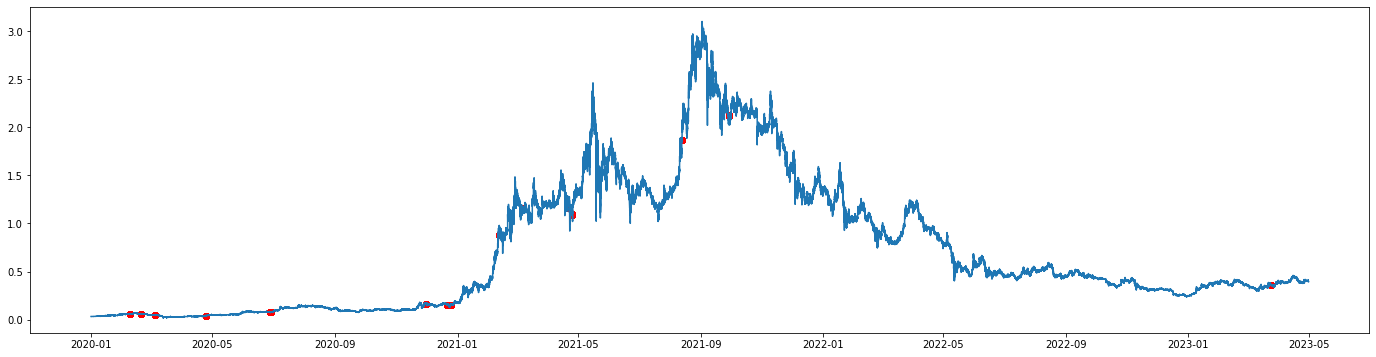

In [220]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_figwidth(24)
fig.set_figheight(6)

plt.plot(df['Open'])

nan_idx = df.loc[df['Open'].isnull()].index
print(f'Legth of nan indexes: {len(nan_idx)} of {len(df)}')
df_interpolated = df.interpolate()
plt.scatter(x=nan_idx, y=df_interpolated['Open'][nan_idx], color='red');

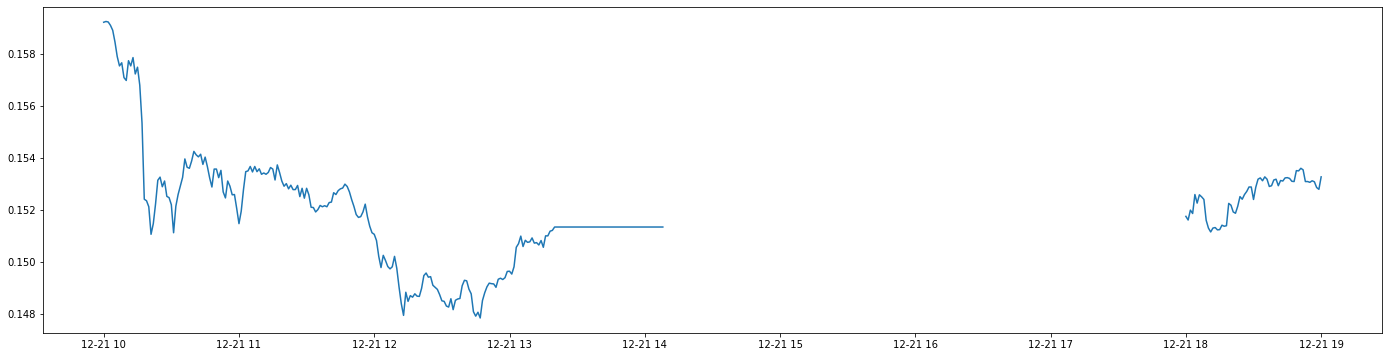

In [246]:
fig = plt.figure()
fig.set_figwidth(24)
fig.set_figheight(6)
plt.plot(df['Open']['2020-12-21 10:00': '2020-12-21 19:00']);

### Interpolation:
    - Wrong data for ML models
    - Simple

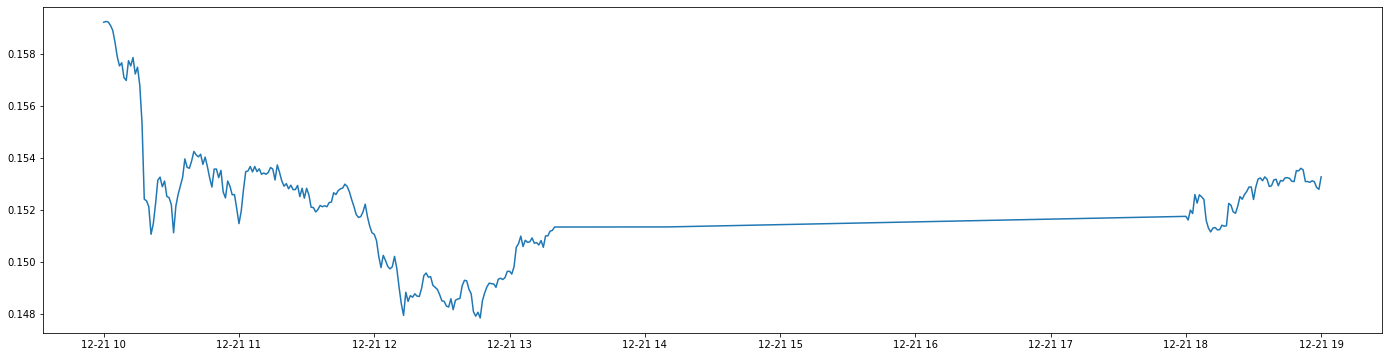

In [247]:
fig = plt.figure()
fig.set_figwidth(24)
fig.set_figheight(6)

df_interpolated = df.interpolate()
plt.plot(df_interpolated['Open']['2020-12-21 10:00': '2020-12-21 19:00'])

### Cutting Missing Data out:
    - Simple
    - Less wrong data for ML models
    - Still flat lines before nan values (These are transaction blocks)

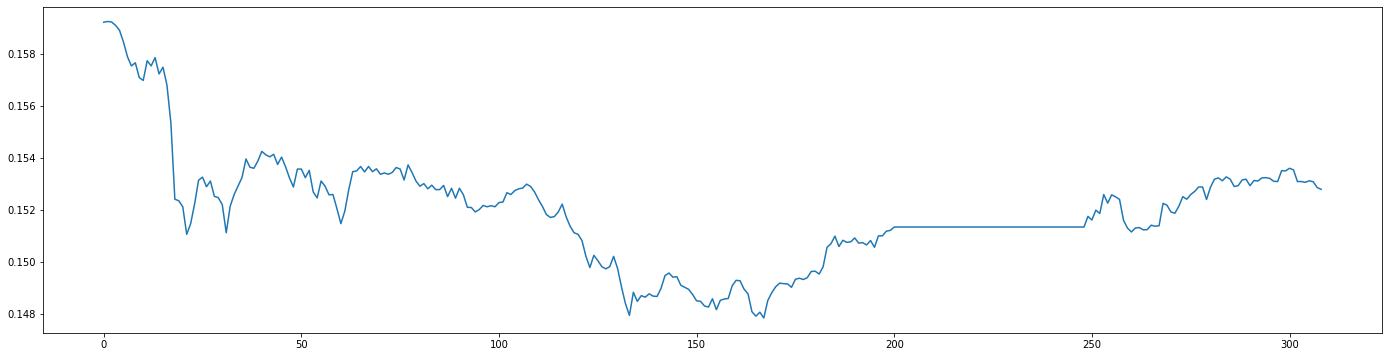

In [348]:
fig = plt.figure()
fig.set_figwidth(24)
fig.set_figheight(6)

series = pd.Series(df_['Open'][511800:512049].append(df_['Open'][512280:512340]))
series.index = np.arange(len(series))
plt.plot(series)

### Replacing Data with Kucoin Exchange:
    - Very cumbersome algorithm
    - Hard maintaining, hard understanding of impact on data quality for research
    - Longer maintaining time
    - No exact volume data; still 0
    - Matches OHLC values of Binance very closly with a similar plot
    
--> Can in fact be a viable solution with additional inputing to flat lines <br>
--> However, it is not worth it for this few nan values due its complexity. 

## Final Recommended Method: Cut Missing and Flat Line Data Out
    - Simple, very understandable
    - Viable for research
    - No disrupting patterns for ML
    - Mostly no price jumps
    - Plotting libraries will just interpolate

## Examples:

### Reading Data in Correctly:

In [4]:
df = pd.read_csv('scalping data/ADA_USDT_1m_2018-04-2023-04.csv', index_col='Time')


df.index = pd.to_datetime(df.index) # Datatype to datetime index
df       = df.asfreq('1T') # Restoring nan values if they were not saved 
__nan_idx = df.loc[df['Open'].isnull()].index
df.fillna(method='ffill', inplace=True) # Flat line interpolating
   

df

,Open,High,Low,Close,Volume
Time,,,,,
2018-04-17 04:02:00,0.25551,0.27000,0.25551,0.27000,111061.62
2018-04-17 04:03:00,0.27000,0.27000,0.26100,0.26108,65024.98
2018-04-17 04:04:00,0.26121,0.26729,0.26120,0.26666,92526.73
2018-04-17 04:05:00,0.26700,0.26800,0.26500,0.26666,75961.21
2018-04-17 04:06:00,0.26770,0.26998,0.26700,0.26995,362270.32
...,...,...,...,...,...
2023-04-30 23:55:00,0.39730,0.39730,0.39680,0.39710,70150.70
2023-04-30 23:56:00,0.39700,0.39700,0.39680,0.39680,19070.00
2023-04-30 23:57:00,0.39690,0.39690,0.39640,0.39640,132369.60


### Cut Out Missing Data and Flat Lines:

    Where consecutive values are equal to each other for at least 45 values data will be cut out
    
    Transaction stops and following shutdowns last usually more than 30 min each in Binance.
    
    The algorithm may filter flat lines for a currency's starting run
    (but only if the currency has generally a very low trading volume).
    This was not observed for the considered currencies.

In [175]:
max_flatline_len = 45 

# Taking Volume to avoid natural flatlines and to detect real transaction stops
cum_count = df.groupby(( df['Volume'] != df['Volume'].shift(1) ).cumsum()).cumcount()+1 # count of consecutie Volume occurences 

# Replace numbers below 'max_flatline_len' with np.nan and backfill with number of 'max_flatline_len'
cum_count.replace(range(1,max_flatline_len+1), np.NaN, inplace=True) 
cum_count.fillna(method='bfill', limit=max_flatline_len-1, inplace=True)  

print(f'Num of Nans: {len(__nan_idx)}')
print(f'Num of flatline datapoints: {len(cum_count.dropna())}')
print(f'{2526} stays for max_flatline_len [15;60]')

filtered_idx = cum_count.dropna().index
df.drop(index=filtered_idx, inplace=True)
#df

Num of Nans: 2326
Num of flatline datapoints: 2526
2526 stays for max_flatline_len [15;60]


## Create a Training Subset of the Fetched Datasets
    - Uniform datasets with the same length are prefered for experiments
        --> Comparibility of results, currency dependent deviations
    - They also should be long enough for a robust ML training 
    - But they may be shorter for faster training and for more representative data for testing

    - Solution:
        - Pick all datasets of a minimum length from every available file
        - clip them at a specific time 
        - and save the subset in another directory

In [52]:
class Dataset_Subset_Extractor:
    def __init__(self, extractor_params):
        self.start_date   = extractor_params['start_date'] 
        self.end_date     = extractor_params['end_date'  ] 
        self.data_dir     = extractor_params['data_dir'  ] 
        self.save_dir     = extractor_params['save_dir'  ] 
        self.file_type    = extractor_params['file_type' ] 
        self.freq         = extractor_params['freq'      ]
        self.freq_pd      = extractor_params['pd_freq'   ] 
        
    def extract_from_all(self):
        data_dir = os.getcwd() + '/' + self.data_dir
        file_names = [(i, j, file_names) for i, j , file_names in os.walk(data_dir)][0][2] # -->  ['BTC_USDT_1m_2020-01-2022-06', ...]
        found_files = [fn for fn in file_names \
                          if ('_'+self.freq+'_' in fn)]
        for fn in tqdm.tqdm(found_files, desc='Extracting dataset subsets'):
            self.df   = self._read_file_to_extract(fn)
            try: 
                idx_start = self.df[self.start_date].index[ 0]
                idx_end   = self.df[self.end_date  ].index[-1]
                self.df   = self.df[idx_start:idx_end]
                print(f'Extracting dataset subset from {fn}')
            except KeyError:
                print(f'Not extracting dataset subset from {fn}. Subset too small')
                continue

            self._save_df(fn)
            
           
        
    def _read_file_to_extract(self, fn):
        file_path_name = f'{self.data_dir}' + '/' + fn
        file_type = fn[-3:]
        try:
            if file_type == 'csv':
                df = pd.read_csv(file_path_name, index_col='Time') 
            elif file_type == 'pkl':
                df = pd.read_pickle(file_path_name)
                self.df.set_index('Time', inplace=True)
            else:
                raise Exception  
        except:
            print(f"Could not find or read the file needed for updating in '{file_path_name}'.")


        df.index = pd.to_datetime(df.index) # Datatype to datetime index
        df       = df.asfreq(self.freq_pd) # Restoring nan values if they were not saved    

        return df

    
    def _save_df(self, fn): 
        first_available_month = str(self.df.index[0])[:7]
        last_available_month = str(self.df.index[-1])[:7]
        fn_split = fn.split('_')
        coin, stable_coin, freq = fn_split[:3]
        
        file_path_name = f'{self.save_dir}/{coin}_{stable_coin}_{freq}_' +\
                         f'{first_available_month}-{last_available_month}.{self.file_type}' 
        # file_path_name --> #'Crypto data/BTCUSDT_1m_2020-01-2022-06.csv'
        
        if self.file_type == 'csv':
            self.df.to_csv(file_path_name) 
        elif self.file_type == 'pkl':
            self.df.to_pickle(file_path_name)
        else:
            raise Exception  
        
    

In [53]:
params = {'freq'     : '1m',
          'pd_freq'  : '1T',
          'file_type'    : 'csv',
          'data_dir'     : 'scalping data', 
          'save_dir'     : 'ExperATAI scalping data',     
          'start_date'   : '2020-01', 
          'end_date'     : '2023-04', # '2023-04' if current date is 29.05.2023!
         }

# Note: csv to pkl file conversion possible on extracting

extractor = Dataset_Subset_Extractor(params)
extractor.extract_from_all()
del extractor

Extracting dataset subsets:   0%|                                                               | 0/39 [00:00<?, ?it/s]

Extracting dataset subset from ADA_USDT_1m_2018-04-2023-04.csv


Extracting dataset subsets:   5%|██▊                                                    | 2/39 [00:23<05:56,  9.65s/it]

Not extracting dataset subset from AGIX_USDT_1m_2023-02-2023-04.csv. Subset too small
Extracting dataset subset from ALGO_USDT_1m_2019-06-2023-04.csv


Extracting dataset subsets:  10%|█████▋                                                 | 4/39 [00:41<04:51,  8.32s/it]

Not extracting dataset subset from APT_USDT_1m_2022-10-2023-04.csv. Subset too small
Not extracting dataset subset from ARB_USDT_1m_2023-03-2023-04.csv. Subset too small
Extracting dataset subset from ARPA_USDT_1m_2019-11-2023-04.csv


Extracting dataset subsets:  15%|████████▍                                              | 6/39 [01:04<05:22,  9.78s/it]

Extracting dataset subset from ATOM_USDT_1m_2019-04-2023-04.csv


Extracting dataset subsets:  21%|███████████▎                                           | 8/39 [01:28<05:12, 10.10s/it]

Not extracting dataset subset from AXS_USDT_1m_2020-11-2023-04.csv. Subset too small
Extracting dataset subset from BNB_USDT_1m_2017-11-2023-04.csv


Extracting dataset subsets:  23%|████████████▋                                          | 9/39 [01:51<06:55, 13.85s/it]

Extracting dataset subset from BCH_USDT_1m_2019-11-2023-04.csv


Extracting dataset subsets:  26%|█████████████▊                                        | 10/39 [02:11<07:35, 15.72s/it]

Extracting dataset subset from BTC_USDT_1m_2017-08-2023-04.csv


Extracting dataset subsets:  31%|████████████████▌                                     | 12/39 [02:39<06:10, 13.72s/it]

Not extracting dataset subset from CFX_USDT_1m_2021-03-2023-04.csv. Subset too small
Extracting dataset subset from DASH_USDT_1m_2019-03-2023-04.csv


Extracting dataset subsets:  33%|██████████████████                                    | 13/39 [02:59<06:45, 15.60s/it]

Extracting dataset subset from DOGE_USDT_1m_2019-07-2023-04.csv


Extracting dataset subsets:  38%|████████████████████▊                                 | 15/39 [03:26<05:27, 13.65s/it]

Not extracting dataset subset from DOT_USDT_1m_2020-08-2023-04.csv. Subset too small
Extracting dataset subset from EOS_USDT_1m_2018-05-2023-04.csv


Extracting dataset subsets:  41%|██████████████████████▏                               | 16/39 [03:48<06:11, 16.15s/it]

Not extracting dataset subset from EDU_USDT_1m_2023-04-2023-04.csv. Subset too small
Extracting dataset subset from ETH_USDT_1m_2017-08-2023-04.csv


Extracting dataset subsets:  46%|████████████████████████▉                             | 18/39 [04:12<04:58, 14.20s/it]

Extracting dataset subset from ETC_USDT_1m_2018-06-2023-04.csv


Extracting dataset subsets:  49%|██████████████████████████▎                           | 19/39 [04:34<05:20, 16.01s/it]

Extracting dataset subset from FET_USDT_1m_2019-02-2023-04.csv


Extracting dataset subsets:  54%|█████████████████████████████                         | 21/39 [04:58<04:03, 13.51s/it]

Not extracting dataset subset from FIL_USDT_1m_2020-10-2023-04.csv. Subset too small
Extracting dataset subset from FTM_USDT_1m_2019-06-2023-04.csv


Extracting dataset subsets:  59%|███████████████████████████████▊                      | 23/39 [05:22<03:06, 11.68s/it]

Not extracting dataset subset from LDO_USDT_1m_2022-05-2023-04.csv. Subset too small
Extracting dataset subset from NEO_USDT_1m_2017-11-2023-04.csv


Extracting dataset subsets:  62%|█████████████████████████████████▏                    | 24/39 [05:44<03:42, 14.81s/it]

Extracting dataset subset from ONT_USDT_1m_2018-06-2023-04.csv


Extracting dataset subsets:  64%|██████████████████████████████████▌                   | 25/39 [06:06<03:54, 16.73s/it]

Extracting dataset subset from KAVA_USDT_1m_2019-10-2023-04.csv


Extracting dataset subsets:  67%|████████████████████████████████████                  | 26/39 [06:27<03:57, 18.23s/it]

Extracting dataset subset from LINK_USDT_1m_2019-01-2023-04.csv


Extracting dataset subsets:  69%|█████████████████████████████████████▍                | 27/39 [06:49<03:50, 19.21s/it]

Extracting dataset subset from LTC_USDT_1m_2017-12-2023-04.csv


Extracting dataset subsets:  74%|████████████████████████████████████████▏             | 29/39 [07:13<02:26, 14.61s/it]

Not extracting dataset subset from MASK_USDT_1m_2021-05-2023-04.csv. Subset too small
Extracting dataset subset from MATIC_USDT_1m_2019-04-2023-04.csv


Extracting dataset subsets:  79%|██████████████████████████████████████████▉           | 31/39 [07:38<01:42, 12.81s/it]

Not extracting dataset subset from SAND_USDT_1m_2020-08-2023-04.csv. Subset too small


Extracting dataset subsets:  82%|████████████████████████████████████████████▎         | 32/39 [07:41<01:07,  9.68s/it]

Not extracting dataset subset from SHIB_USDT_1m_2021-05-2023-04.csv. Subset too small


Extracting dataset subsets:  85%|█████████████████████████████████████████████▋        | 33/39 [07:43<00:45,  7.59s/it]

Not extracting dataset subset from SOL_USDT_1m_2020-08-2023-04.csv. Subset too small
Extracting dataset subset from TRX_USDT_1m_2018-06-2023-04.csv


Extracting dataset subsets:  90%|████████████████████████████████████████████████▍     | 35/39 [08:12<00:39,  9.91s/it]

Not extracting dataset subset from UNI_USDT_1m_2020-09-2023-04.csv. Subset too small
Extracting dataset subset from VET_USDT_1m_2018-07-2023-04.csv


Extracting dataset subsets:  92%|█████████████████████████████████████████████████▊    | 36/39 [08:38<00:44, 14.90s/it]

Extracting dataset subset from WAVES_USDT_1m_2019-01-2023-04.csv


Extracting dataset subsets:  95%|███████████████████████████████████████████████████▏  | 37/39 [09:00<00:33, 16.88s/it]

Extracting dataset subset from XRP_USDT_1m_2018-05-2023-04.csv


Extracting dataset subsets:  97%|████████████████████████████████████████████████████▌ | 38/39 [09:23<00:18, 18.87s/it]

Extracting dataset subset from ZEC_USDT_1m_2019-03-2023-04.csv


Extracting dataset subsets: 100%|██████████████████████████████████████████████████████| 39/39 [09:44<00:00, 14.97s/it]


## Fetching Secondly Data
    - Fetch and save annually as of high RAM requirements
    - Saving in Pickle files for speed and saving disk space
    - Data may be useful later for showing off/ for analysis
    
    - If more RAM available, do concat these files

In [186]:
fetched_coins = ['BTC', 'ADA', 'DOGE', 'ETH', 'BNB', 'XRP']
for c in fetched_coins:
    for i in range(2023, 2023 + 1): # Save yearly beacause of RAM requirements
        params = {'coins' : [c], 
                  'freq'  : '1s',
                  'pd_freq'  : '1S',
                  #['ADA','ALGO','ARPA','ATOM','AXS','BNB','BCH','BTC','CFX','DOGE','DOT','EDU','EOS','ETC','ETH','FET',
                  #'FIL','FTM','LDO','NEO','ONT','KAVA','LINK','LTC','MATIC','SAND','SOL','SHIB','TRX','UNI','VET','XMRF',
                  #'XRP','ZEC']  
                  'stable_coin'  : 'USDT',
                  'save_dir'     : 'scalping data',  
                  'file_type'    : 'pkl',
                  'start_date'   : f'{i}-01-01', 
                  'end_date'     : f'{i}-12-01'
                 }

        fetcher = Scalping_Dataset_Fetcher(params)
        fetcher.init_and_run_fetching()
        
del fetcher # freeing RAM

2023-05
['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12']
['2023-01', '2023-02', '2023-03', '2023-04']


Download ticker months of BTCUSDT: 100%|█████████████████████████████████████████████████| 4/4 [00:50<00:00, 12.63s/it]


Total Nan values: 8771


In [ ]:
def concat files

In [ ]:
# TODO: concat files 

In [10]:
df = df['2018-04-17 04:04:00' : '2018-04-17 04:06:00']
df

,Open,High,Low,Close,Volume
Time,,,,,
2018-04-17 04:04:00,0.26121,0.26729,0.2612,0.26666,92526.73
2018-04-17 04:05:00,0.26700,0.26800,0.2650,0.26666,75961.21
2018-04-17 04:06:00,0.26770,0.26998,0.2670,0.26995,362270.32


In [ ]:
except Key

In [6]:
df = pd.read_csv('scalping data/BNB_USDT_1m_2017-11-2023-04.csv', index_col='Time')


df.index = pd.to_datetime(df.index) # Datatype to datetime index
df       = df.asfreq('1T') # Restoring nan values if they were not saved 
__nan_idx = df.loc[df['Open'].isnull()].index
df.fillna(method='ffill', inplace=True) # Flat line interpolating
   

df

,Open,High,Low,Close,Volume
Time,,,,,
2017-11-06 03:54:00,1.5,1.50,1.5,1.50,10.830
2017-11-06 03:55:00,1.3,1.30,1.3,1.30,1.000
2017-11-06 03:56:00,1.3,1.30,0.5,0.50,19.000
2017-11-06 03:57:00,0.5,0.61,0.5,0.61,253.000
2017-11-06 03:58:00,1.1,1.10,1.1,1.10,85.000
...,...,...,...,...,...
2023-04-30 23:55:00,337.7,338.30,337.7,338.00,4997.282
2023-04-30 23:56:00,338.0,338.30,338.0,338.20,937.007
2023-04-30 23:57:00,338.2,338.30,337.9,338.10,1869.750


In [9]:
import sys

In [24]:
sys.getsizeof(df)/10**6 * 4

553.468128